# Processing the results

In [1]:
import os
import random
import collections
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.ion()
sns.set_context('paper', font_scale=2, rc={'lines.linewidth': 2})
sns.set_style(style='whitegrid')

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%reload_ext autoreload
%autoreload 2

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

In [3]:
import sys
sys.path.insert(0, '../')

In [4]:
def num_params(net):
    return np.sum([v.numel() for v in net.parameters()])

## Visualizing the datasets

In [5]:
import glob
import torch
from skimage import io
from torchvision.utils import make_grid
from torch.utils.data import Dataset
from torchvision.datasets.folder import default_loader
from torchvision.transforms import Compose
from cpe775 import transforms
from cpe775.utils import img_utils, io_utils

In [6]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None, dataset_name=None, loader=default_loader):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
            loader (callable, optional): A function to load an image given its path.
        """
        self.data_df = pd.read_csv(csv_file, header=None)
        self.root_dir = root_dir
        self.transform = transform
        self.loader = loader
        
        if dataset_name is not None:
            self.data_df = self.data_df[self.data_df.iloc[:, 0].str.contains(dataset_name)].reset_index(drop=True)

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_df.ix[idx, 0])
        image = self.loader(img_name)

        landmarks = self.data_df.ix[idx, 1:].as_matrix().astype('float32')
        landmarks = landmarks.reshape(-1, 2)

        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [100]:
def show_landmarks_batch(sample_batched, normalized=True, nrow=8, padding=2, ylabels=None):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    plt.axes(frameon=False)
    grid = make_grid(images_batch, nrow, padding)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    ncol = np.ceil(batch_size/nrow).astype('int')

    for j in range(ncol):
        for i in range(nrow):
            if i+ j*nrow >= len(landmarks_batch):
                continue

            plt.scatter(landmarks_batch[i+ j*nrow, :, 0].numpy()*im_size + i * im_size + padding*i,
                        landmarks_batch[i+j*nrow, :, 1].numpy()*im_size + j * im_size + padding*j,
                        s=10, marker='.', c='r')

        if ylabels is not None:
            plt.text(-im_size/3, im_size/2 + j*im_size - 24, ylabels[j], rotation=90)
        plt.tick_params(which='both', labelbottom='off', labeltop='off', labelleft='off', labelright='off', width=0)

In [8]:
plt.figtext?

In [128]:
transform = Compose([transforms.CropFace(enlarge_ratio=0),
                     transforms.ToTensor()])
dataset = torch.utils.data.ConcatDataset([FaceLandmarksDataset('../data/train.csv', '../data/', transform=transform),
                                          FaceLandmarksDataset('../data/challenging_test.csv', '../data/', transform=transform),
                                          FaceLandmarksDataset('../data/common_test.csv', '../data/', transform=transform),
                                          FaceLandmarksDataset('../data/w300_test.csv', '../data/', transform=transform)])

dt_idxs = []
for dataset_name in ['helen', 'afw', 'lfpw', 'ibug', '300W']:
    idxs = [dt.data_df.iloc[:, 0].str.contains(dataset_name) for dt in dataset.datasets]
    idxs = [idx for ids in idxs for idx in ids]
    idxs = [i for i, x in enumerate(idxs) if x]
    
    dt_idxs.extend(np.random.choice(idxs, 8)) 

/home/igor.quintanilha/miniconda3/envs/dsc/lib/python3.5/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


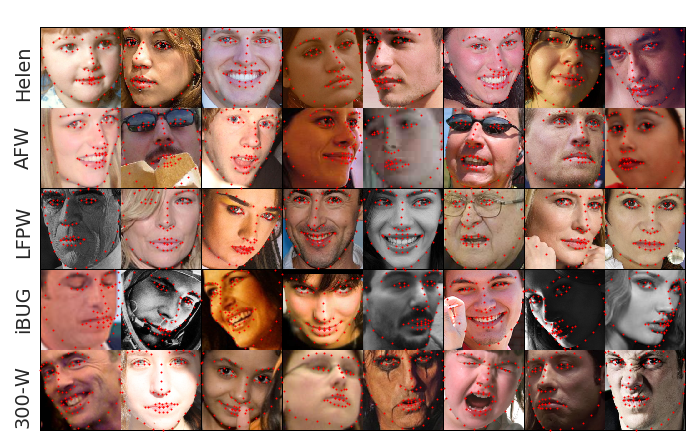

In [129]:
batch = torch.utils.data.dataloader.default_collate([dataset[i] for i in dt_idxs])
show_landmarks_batch(batch, padding=2, nrow=8, ylabels=['Helen', 'AFW', 'LFPW', 'iBUG', '300-W'])
plt.grid(False)
plt.tight_layout()
plt.savefig('figs/{}.pdf'.format(dataset_name), dpi=300, bbox_inches='tight')
plt.show()

## Loading the experiments

In [13]:
from collections import OrderedDict
from cpe775.networks.toy import BaseNet, CNNNet
from cpe775.networks.resnet import resnet18, resnet34

In [14]:
import torch

In [282]:
ckpts = OrderedDict([('BaseNet', torch.load('../results/basenet/checkpoint-v2.pth.tar')),
                     ('CNNNet', torch.load('../results/cnnnet/checkpoint.pth.tar')),
                     ('CNNNet + Data Aug.', torch.load('../results/cnnnet/checkpoint-data-aug.pth.tar')),
                     ('ResNet 18 (1C)', torch.load('../results/resnet/resnet-18-1c-nrmse.pth.tar')),
                     ('ResNet 34 (1C)', torch.load('../results/resnet/resnet-34-1c.pth.tar'))])

In [283]:
print('# Number of parameters')
for name, ckpt in ckpts.items():
    print('{}, {}'.format(name, num_params(ckpt['net'])))

# Number of parameters
BaseNet, 19702036
CNNNet, 17200264
CNNNet + Data Aug., 13268104
ResNet 18 (1C), 718072
ResNet 34 (1C), 2237496


In [284]:
# colors = sns.color_palette(n_colors=len(ckpts)).as_hex()
colors = sns.color_palette("Dark2", len(ckpts)).as_hex()
markers = ['o',  '<', 's', 'v', 'H', '>', 'p', 'D', '^']

In [285]:
import matplotlib.gridspec as gridspec

In [286]:
markersize=8

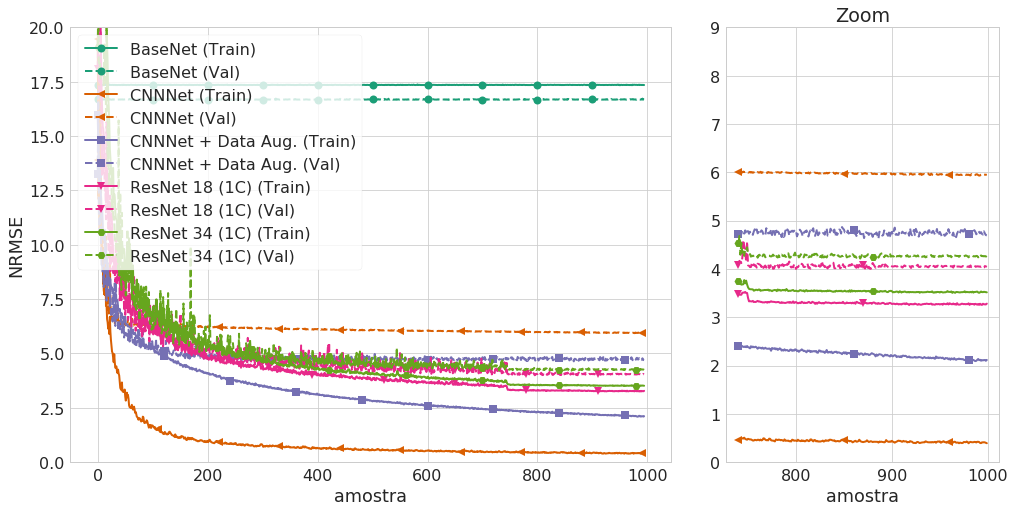

In [294]:
plt.figure(figsize=(30,8))
gs = gridspec.GridSpec(3, 3)
gs.update(left=0.55, right=0.98, hspace=0.05)
ax1 = plt.subplot(gs[:, :-1])
ax2 = plt.subplot(gs[:, -1])

for i, (name, ckpt) in enumerate(ckpts.items()):
    if 'val_rmse' in ckpt['history']:
        train_loss = ckpt['history']['train_rmse']
        val_loss = ckpt['history']['val_rmse']
    else:
        train_loss = ckpt['history']['train_nrmse']
        val_loss = ckpt['history']['val_nrmse']
        
    ax1.plot(train_loss[5:], label='{} (Train)'.format(name), color=colors[i], marker=markers[i], markevery=100 + 10*i, ms=markersize)
    ax1.plot(val_loss[5:], label='{} (Val)'.format(name), color=colors[i], linestyle='--', marker=markers[i], markevery=100 + 10*i, ms=markersize)
    ax2.plot(range(740, 1000), train_loss[740:], label='{} (Train)'.format(name), color=colors[i], marker=markers[i], markevery=100 + 10*i, ms=markersize)
    ax2.plot(range(740, 1000), val_loss[740:], label='{} (Val)'.format(name), color=colors[i], linestyle='--', marker=markers[i], markevery=100 + 10*i, ms=markersize)

ax1.set_ylim([0, 20])
# plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
ax1.legend(loc='upper left', frameon=True)
ax1.set_ylabel('NRMSE')
ax1.set_xlabel('amostra')
ax2.set_xlabel('amostra')
ax2.set_title('Zoom')
ax2.set_ylim([0, 9])
plt.savefig('figs/results.pdf', dpi=300, bbox_inches='tight')

In [21]:
def get_transform(name):
    if name == 'BaseNet' or name == 'CNNNet':
            transform = Compose([transforms.CropFace(enlarge_ratio=1.7),
                                 transforms.ToGray(),
                                 transforms.ToTensor()])
    elif '3C' in name:
        transform = Compose([transforms.CropFace(enlarge_ratio=1.7),
                             transforms.CenterCrop(224),
                             transforms.ToTensor()])
    else:
        transform = Compose([transforms.CropFace(enlarge_ratio=1.7),
                             transforms.ToGray(),
                             transforms.CenterCrop(224),
                             transforms.ToTensor()])
    return transform

In [61]:
preds = {k: [] for k in ckpts.keys()}
origs = {k: [] for k in ckpts.keys()}
images = {k: [] for k in ckpts.keys()}

for name, ckpt in ckpts.items():
    transform = get_transform(name)
    dataset = torch.utils.data.ConcatDataset([FaceLandmarksDataset('../data/challenging_test.csv', '../data/', transform=transform),
                                              FaceLandmarksDataset('../data/common_test.csv', '../data/', transform=transform),
                                              FaceLandmarksDataset('../data/w300_test.csv', '../data/', transform=transform)])

    loader = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=False, num_workers=4)
    
    net = ckpt['net'].module.cpu()
    net = net.cuda()
    net.eval()
    
    for batch in loader:
        image = batch['image']

        preds[name].append(net(torch.autograd.Variable(image, volatile=True).cuda()).data.cpu().numpy())
        images[name].append(image)
        origs[name].append(batch['landmarks'])
        
    del net

/home/igor.quintanilha/miniconda3/envs/dsc/lib/python3.5/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/igor.quintanilha/miniconda3/envs/dsc/lib/python3.5/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/igor.quintanilha/miniconda3/envs/dsc/lib/python3.5/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/igor.quintanilha/minicond

/home/igor.quintanilha/miniconda3/envs/dsc/lib/python3.5/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/igor.quintanilha/miniconda3/envs/dsc/lib/python3.5/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/igor.quintanilha/miniconda3/envs/dsc/lib/python3.5/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/home/igor.quintanilha/minicond

In [62]:
for name in ckpts.keys():
    print(len(np.vstack(preds[name])))

1289
1289
1289
1289
1289
1289
1289
1289


In [63]:
preds = {k: np.vstack(v) for k, v in preds.items()}
origs = {k: np.vstack(v) for k, v in origs.items()}
images = {k: np.vstack(v) for k, v in images.items()}

## Losses

In [292]:
from cpe775.criterion import NRMSELoss, NMSELoss

nrmse = NRMSELoss()
nmse = NMSELoss()

In [220]:
first = len(FaceLandmarksDataset('../data/challenging_test.csv', '../data/', transform=transform))
second = len(FaceLandmarksDataset('../data/common_test.csv', '../data/', transform=transform))
third = len(FaceLandmarksDataset('../data/w300_test.csv', '../data/', transform=transform))

In [221]:
idxs = np.cumsum([0, first, second, third])

In [293]:
for name in ckpts.keys():
    
    loss = nrmse(torch.from_numpy(origs[name][idxs[1]:idxs[2]]), torch.from_numpy(preds[name][idxs[1]:idxs[2]]))
    print('{} - Common - {:.5f}'.format(name, loss))
    loss = nmse(torch.from_numpy(origs[name][idxs[1]:idxs[2]]), torch.from_numpy(preds[name][idxs[1]:idxs[2]]))
    print('{} - (NMSE) Common - {:.5f}'.format(name, loss))
    
    loss = nrmse(torch.from_numpy(origs[name][:idxs[1]]), torch.from_numpy(preds[name][:idxs[1]]))
    print('{} - Challenging - {:.5f}'.format(name, loss))
    loss = nmse(torch.from_numpy(origs[name][:idxs[1]]), torch.from_numpy(preds[name][:idxs[1]]))
    print('{} - (NMSE) Challenging - {:.5f}'.format(name, loss))
    
    loss = nrmse(torch.from_numpy(origs[name][idxs[2]:idxs[3]]), torch.from_numpy(preds[name][idxs[2]:idxs[3]]))
    print('{} - 300-W - {:.5f}'.format(name, loss))   
    loss = nmse(torch.from_numpy(origs[name][idxs[2]:idxs[3]]), torch.from_numpy(preds[name][idxs[2]:idxs[3]]))
    print('{} - (NMSE) 300-W - {:.5f}'.format(name, loss))

BaseNet - Common - 0.22397
BaseNet - (NMSE) Common - 4.05586
BaseNet - Challenging - 0.40613
BaseNet - (NMSE) Challenging - 11.71280
BaseNet - 300-W - 0.28672
BaseNet - (NMSE) 300-W - 6.55740
CNNNet - Common - 0.08050
CNNNet - (NMSE) Common - 0.54147
CNNNet - Challenging - 0.19053
CNNNet - (NMSE) Challenging - 2.93347
CNNNet - 300-W - 0.13150
CNNNet - (NMSE) 300-W - 1.42207
CNNNet + Data Aug. - Common - 0.06610
CNNNet + Data Aug. - (NMSE) Common - 0.42293
CNNNet + Data Aug. - Challenging - 0.12848
CNNNet + Data Aug. - (NMSE) Challenging - 1.46322
CNNNet + Data Aug. - 300-W - 0.09753
CNNNet + Data Aug. - (NMSE) 300-W - 0.86103
ResNet 18 (1C) - Common - 0.05641
ResNet 18 (1C) - (NMSE) Common - 0.31624
ResNet 18 (1C) - Challenging - 0.12103
ResNet 18 (1C) - (NMSE) Challenging - 1.46194
ResNet 18 (1C) - 300-W - 0.08752
ResNet 18 (1C) - (NMSE) 300-W - 0.74186
ResNet 34 (1C) - Common - 0.05745
ResNet 34 (1C) - (NMSE) Common - 0.32707
ResNet 34 (1C) - Challenging - 0.13351
ResNet 34 (1C) - (N

In [288]:
transform = Compose([transforms.CropFace(enlarge_ratio=1.7),
                     transforms.ToTensor()])
dataset = torch.utils.data.ConcatDataset([FaceLandmarksDataset('../data/challenging_test.csv', '../data/', transform=transform),
                                          FaceLandmarksDataset('../data/common_test.csv', '../data/', transform=transform),
                                          FaceLandmarksDataset('../data/w300_test.csv', '../data/', transform=transform)])

In [289]:
import cv2
import dlib

In [290]:
from cpe775.face_detector import LandmarksDetector

for name, ckpt in ckpts.items():
    try:
        os.makedirs('figs/{}'.format(name))
    except FileExistsError as e:
        if e.errno != 17:
            raise e
            
    net = ckpt['net'].module.cpu()
    net.eval()
    
    if name == 'BaseNet' or name == 'CNNNet':
        to_gray = True
        crop = None
    elif '3C' in name:
        to_gray = False
        crop = 224
    else:
        to_gray = True
        crop = 224
        
    landmarks_detector = LandmarksDetector(net, None, cuda=True)
    
    for i, data in enumerate(dataset):
        image, landmarks = data['image'], data['landmarks']
        image = np.ascontiguousarray((np.array(image).copy()[::-1, :, :].transpose((1,2,0))*255).astype(np.uint8))
        
        w, h = image.shape[:-1]
        
        face_rect = dlib.rectangle(0, 0, w, h)
        
        # Find the landmarks given the image and the bounding boxes
        pred_landmarks, rect = landmarks_detector.from_rect(image, face_rect, enlarge_ratio=0, to_gray=to_gray, crop=crop)

        for (x, y) in pred_landmarks:
             cv2.circle(image, (int(x), int(y)), 2, (0, 0, 255), -1)
        
#         plt.imshow(image)
#         plt.show()
#         break
#     break
        cv2.imwrite('figs/{}/{}.jpg'.format(name, i), image)

/home/igor.quintanilha/miniconda3/envs/dsc/lib/python3.5/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
